In [72]:
import warnings

warnings.filterwarnings('ignore')
import os
import re
import string

import joblib
import matplotlib.pyplot as plt
import pickle
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.layers import (Bidirectional, Dense, Dropout,
                                     Embedding)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

import wandb
from wandb.keras import WandbCallback

In [73]:
def plot_conf_matrix(y_pred, y_true, title=None):
    """Helper Function to plot confustion matrix"""
    conf_mat = confusion_matrix(y_pred, y_true)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Fake", "Real"]],
                  columns = [i for i in ["Fake", "Real"]])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="Blues")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    if title:
        plt.title(f"{title} Confusion Matrix")
    plt.show()

# Read in Data and Preprocess

In [74]:
true_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/trueNews.csv")
fake_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/fakeNews.csv")
# Assign class columns and combine dataframes
fake_news_df["class"] = 1
true_news_df["class"] = 0
combined = pd.concat([fake_news_df, true_news_df], axis=0)

In [75]:
fake_news_df[fake_news_df["Text"].str.contains("Bill Gates is working")]["Text"].values
 # Bill Gates is working on an electronic chip to implant under human skin in order to locate and control people.\t\t

array([' Bill Gates is working on an electronic chip to implant under human skin in order to locate and control people.\t\t'],
      dtype=object)

In [76]:
true_news_df[true_news_df["Text"].str.contains("beyond recognition")]["Text"].values
# 'Covid-19 can damage lungs of victims beyond recognition, expert says  https://www.theguardian.com/world/2020/jun/15/covid-19-can-damage-lungs-victims-beyond-recognition-expert-says?utm_term=Autofeed&CMP=twt_b-gdnnews&utm_medium=Social&utm_source=Twitter#Echobox=1592245639\xa0'],

array(['Covid-19 can damage lungs of victims beyond recognition, expert says  https://www.theguardian.com/world/2020/jun/15/covid-19-can-damage-lungs-victims-beyond-recognition-expert-says?utm_term=Autofeed&CMP=twt_b-gdnnews&utm_medium=Social&utm_source=Twitter#Echobox=1592245639\xa0'],
      dtype=object)

In [77]:
# Subset data to just contain the text field and the class field
combined = combined[["Text", "class"]].reset_index(drop=True)
# Shuffle data
combined = combined.sample(frac = 1, random_state=42)

In [78]:
combined['Text'] = combined['Text'].str.replace('http\S+|www.\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('pic\S+|twitter.\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('#\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('@\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('Link:\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('[ \t]+$', '', case=False)
# remove front and ending blank spaces
combined = combined.replace({"^\s*|\s*$":""}, regex=True) 

def format_text(text):
    """Formating of the text field """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    text = re.sub(' +', ' ', text)
    return text

combined["Text"] = combined["Text"].apply(format_text)

In [79]:
# Set X and y variables
X = combined["Text"]
y = combined["class"]

In [81]:
# Split data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [82]:
# Apply TDidf Vectorization to the input data 
vectorization = TfidfVectorizer()
X_train = vectorization.fit_transform(X_train)
joblib.dump(vectorization, 'tfidf_vectorizer.pkl')
vectorization = joblib.load('tfidf_vectorizer.pkl')
X_test = vectorization.transform(X_test)

# Model 1: Naive Bayes Model

In [12]:
# Default hyper-parameter model
nb_model = MultinomialNB()
# Fit model 
nb_model.fit(X_train, y_train)
# Predict 
y_pred = nb_model.predict(X_test)

In [13]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8929889298892989


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       938
           1       0.90      0.89      0.89       959

    accuracy                           0.89      1897
   macro avg       0.89      0.89      0.89      1897
weighted avg       0.89      0.89      0.89      1897



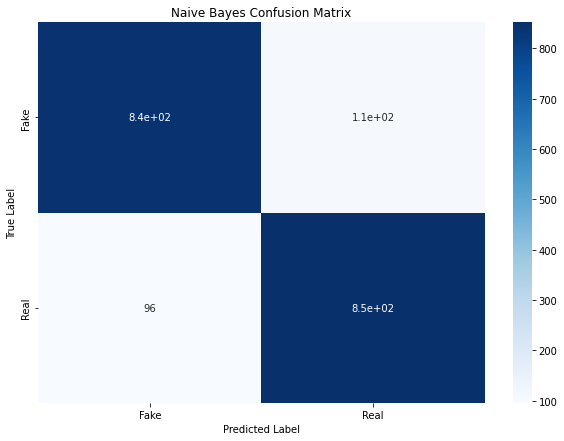

In [15]:
plot_conf_matrix(y_pred, y_test, title="Naive Bayes")

In [16]:
# GridSearch Across hyper-parameter search space
params = {
    "alpha": [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.5, 2, 3, 5, 10],
    "fit_prior": (True, False),
}
gs_clf = GridSearchCV(MultinomialNB(), params, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

In [27]:
# Save Naive Bayes Model 
joblib.dump(gs_clf.best_estimator_, 'naive_bayes.pkl')

['naive_bayes.pkl']

In [30]:
best_nb_model = joblib.load('naive_bayes.pkl')

In [31]:
y_pred = best_nb_model.predict(X_test)

In [32]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test Precision: {precision_score(y_test, y_pred)}")
print(f"Test Recall: {recall_score(y_test, y_pred)}")
print(f"Test f1 Score: {f1_score(y_test, y_pred)}")
print(f"Test roc auc score: {roc_auc_score(y_test, y_pred)}")

Test Accuracy: 0.889826041117554
Test Precision: 0.8972457627118644
Test Recall: 0.8832116788321168
Test f1 Score: 0.8901734104046244
Test roc auc score: 0.8899000824864209


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       938
           1       0.90      0.88      0.89       959

    accuracy                           0.89      1897
   macro avg       0.89      0.89      0.89      1897
weighted avg       0.89      0.89      0.89      1897



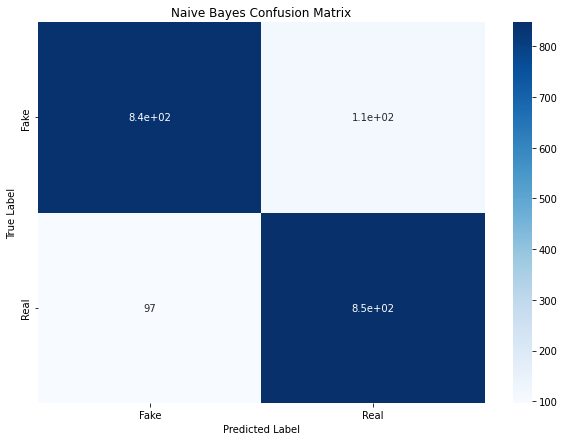

In [34]:
plot_conf_matrix(y_pred, y_test, title="Naive Bayes")

# Model 2: Gradient Boosting Classifier

In [51]:
gbt_model = GradientBoostingClassifier()
# Fit model 
gbt_model.fit(X_train, y_train)
# Predict 
y_pred = gbt_model.predict(X_test)

In [52]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test Precision: {precision_score(y_test, y_pred)}")
print(f"Test Recall: {recall_score(y_test, y_pred)}")
print(f"Test f1 Score: {f1_score(y_test, y_pred)}")
print(f"Test roc auc score: {roc_auc_score(y_test, y_pred)}")

Test Accuracy: 0.8529256721138639
Test Precision: 0.8794642857142857
Test Recall: 0.821689259645464
Test f1 Score: 0.8495956873315365
Test roc auc score: 0.8532753334474654


In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       938
           1       0.88      0.83      0.85       959

    accuracy                           0.85      1897
   macro avg       0.86      0.85      0.85      1897
weighted avg       0.86      0.85      0.85      1897



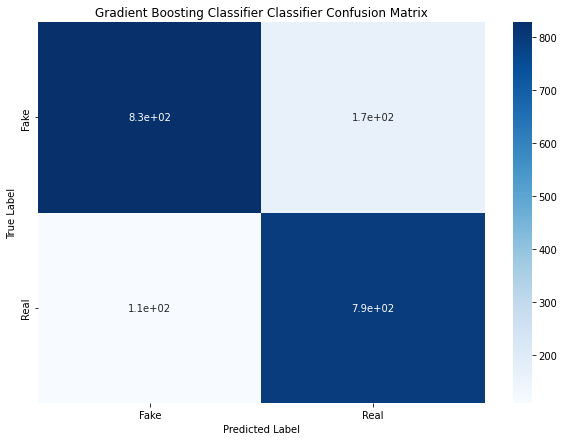

In [38]:
plot_conf_matrix(y_pred, y_test, title="Gradient Boosting Classifier Classifier")

In [39]:
%%time
params = {
    "loss": ["deviance", "exponential"],
    "learning_rate": [0.001, 0.01, 0.1, 1, 2],
    "n_estimators": [10, 50, 100, 500],
    "subsample": [0.5, 0.75, 1.0],
}
gs_clf = GridSearchCV(GradientBoostingClassifier(), params, n_jobs=-1, scoring='accuracy')
  
gs_clf = gs_clf.fit(X_train, y_train)

CPU times: user 5.71 s, sys: 160 ms, total: 5.87 s
Wall time: 4min 54s


In [40]:
# Save Naive Bayes Model 
joblib.dump(gs_clf.best_estimator_, 'gradient_boosting.pkl')

['gradient_boosting.pkl']

In [41]:
best_gb_model = joblib.load('gradient_boosting.pkl')
# Predict 
y_pred = best_gb_model.predict(X_test)

In [38]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test Precision: {precision_score(y_test, y_pred)}")
print(f"Test Recall: {recall_score(y_test, y_pred)}")
print(f"Test f1 Score: {f1_score(y_test, y_pred)}")
print(f"Test roc auc score: {roc_auc_score(y_test, y_pred)}")

Test Accuracy: 0.8522071164997364
Test Precision: 0.8791838316722038
Test Recall: 0.8831838316722038
Test f1 Score: 0.8501722878625135
Test roc auc score: 0.8730628920050426


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       938
           1       0.90      0.88      0.89       959

    accuracy                           0.89      1897
   macro avg       0.89      0.89      0.89      1897
weighted avg       0.89      0.89      0.89      1897



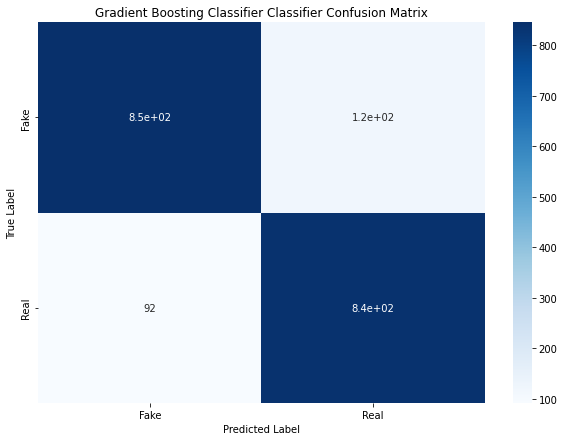

In [44]:
plot_conf_matrix(y_pred, y_test, title="Gradient Boosting Classifier Classifier")

# Bidirectional LSTM 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [46]:
# Perform parameter sweep using Weights and Biases

wandb.init(project="my-test-project", entity="tripleblackcat")

sweep_config = {
    "name": "b-lstm",
    "metric": {"name": "val_f1", "goal": "maximize"},
    "method": "random",
    "parameters": {
        "epochs": {"values": [10, 20, 40]},
        "lr": {"values": [0.005, 0.001, 0.0005, 0.0001]},
        "batch_size": {"values": [64, 128, 256]},
        "max_tokens": {"values": [100, 1000, 5000, None]},
        "embedding_dim": {"values": [16, 32, 64, 256]},
        "lstm_units": {"values": [16, 32, 64, 256]},
        "ff_size": {"values": [64, 128, 256]},
        "dropout": {"values": [0, 0.5]}
    }
}
def get_lstm(config, encoder, vocab_size):
    LSTM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=config.embedding_dim,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.lstm_units)),
    tf.keras.layers.Dense(config.ff_size, activation="relu"),
    tf.keras.layers.Dropout(config.dropout),
    tf.keras.layers.Dense(1)
    ])
    return LSTM

def sweep():
    with wandb.init() as run:
        config = wandb.config 

        max_tokens = config.max_tokens
        encoder = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
        encoder.adapt(X_train)

        vocab_size = len(encoder.get_vocabulary())

        lstm = get_lstm(config, encoder, vocab_size)
        lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                     optimizer=tf.keras.optimizers.Adam(config.lr),
                     metrics=["accuracy"])

        lstm.fit(X_train, 
                 y_train, 
                 validation_data=(X_val, y_val), 
                 epochs=config.epochs,
                 callbacks=[WandbCallback()])
       
        y_pred = np.around(tf.math.sigmoid(lstm.predict(X_test))).flatten()
        wandb.log({"val_f1": f1_score(y_test, y_pred)})
        del lstm

sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, sweep, count=50)
# https://wandb.ai/tripleblackcat/uncategorized/sweeps/aoizs7rc/table?workspace=user-tripleblackcat

In [29]:
# Train multiple times and average out results
# Use best model parameters from sweep
accuracies = []
precisions = []
recalls = []
f1s = []

runs = 10

max_tokens = None
encoder = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
encoder.adapt(X_train)
vocab_size = len(encoder.get_vocabulary())
for i in range(runs):
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)
    y_pred = np.around(tf.math.sigmoid(model.predict(X_test))).flatten()
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

Epoch 1/10
67/67 [==============================] - 6s 31ms/step - loss: 0.6917 - accuracy: 0.4953 - val_loss: 0.6893 - val_accuracy: 0.5207
Epoch 2/10
67/67 [==============================] - 1s 10ms/step - loss: 0.6850 - accuracy: 0.4953 - val_loss: 0.6761 - val_accuracy: 0.5207
Epoch 3/10
67/67 [==============================] - 1s 10ms/step - loss: 0.6411 - accuracy: 0.4998 - val_loss: 0.5725 - val_accuracy: 0.5453
Epoch 4/10
67/67 [==============================] - 1s 10ms/step - loss: 0.4672 - accuracy: 0.7235 - val_loss: 0.4111 - val_accuracy: 0.8103
Epoch 5/10
67/67 [==============================] - 1s 10ms/step - loss: 0.3459 - accuracy: 0.8526 - val_loss: 0.3442 - val_accuracy: 0.8700
Epoch 6/10
67/67 [==============================] - 1s 10ms/step - loss: 0.3033 - accuracy: 0.8880 - val_loss: 0.3214 - val_accuracy: 0.8897
Epoch 7/10
67/67 [==============================] - 1s 10ms/step - loss: 0.2553 - accuracy: 0.9084 - val_loss: 0.2903 - val_accuracy: 0.8911
Epoch 8/10
67

In [53]:
print(f"Test Accuracy: {np.array(accuracies).sum()/runs}")
print(f"Test Precision: {np.array(precisions).sum()/runs}")
print(f"Test Recall: {np.array(recalls).sum()/runs}")
print(f"Test F1 Score: {np.array(f1s).sum()/runs}")

Test Accuracy: 0.8971271481286241
Test Precision: 0.916304024364115
Test Recall: 0.8781261730969762
Test F1 Score: 0.8995758957890096


In [31]:
# Saving via model.save() and load_model was not working
# Had to save model weights and load explicitly
def create_model():
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])
    return model

In [32]:
# Save the weights
model.save_weights('bilstm/my_checkpoint')

# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('bilstm/my_checkpoint')

In [33]:
y_pred = np.around(tf.math.sigmoid(model.predict(X_test))).flatten()